## Tiny Imagenet 

In [1]:
import os
# os.environ['CUDA_VISIBLE_DEVICES']='1'

In [2]:
import timm, torch, random, datasets, math, fastcore.all as fc, numpy as np, matplotlib as mpl, matplotlib.pyplot as plt
import torchvision.transforms as T
import torchvision.transforms.functional as TF,torch.nn.functional as F

from torch.utils.data import DataLoader,default_collate
from pathlib import Path
from torch.nn import init
from fastcore.foundation import L
from torch import nn,tensor
from datasets import load_dataset
from operator import itemgetter
from torcheval.metrics import MulticlassAccuracy
from functools import partial
from torch.optim import lr_scheduler
from torch import optim
from torchvision.io import read_image,ImageReadMode

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.accel import *
from miniai.training import *

In [3]:
from fastprogress import progress_bar
from glob import glob

In [4]:
torch.set_printoptions(precision=5, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['figure.dpi'] = 70

set_seed(42)
if fc.defaults.cpus>7: fc.defaults.cpus=7

### Data Processing 

In [5]:
path_data = Path('/home/datasets/data')
path_data.mkdir(exist_ok=True)
path_to_dataset = path_data / 'tiny-imagenet-200'
path_to_dataset.mkdir(exist_ok=True)

In [6]:
url = 'http://cs231n.stanford.edu/tiny-imagenet-200.zip'
if not path_data.exists():
    path_zip = fc.urlsave(url, path_data)
    shutil.unpack_archive(path_data/'tiny-imagenet-200.zip', path_data)

In [7]:
bs = 512
# bs = 32
xmean,xstd = (tensor([0.47565, 0.40303, 0.31555]), 
              tensor([0.28858, 0.24402, 0.26615]))

In [8]:
tfms = nn.Sequential(T.Pad(8), T.RandomCrop(64), T.RandomHorizontalFlip())

In [9]:
class TinyDS:
    def __init__(self, path):
        self.path = Path(path)
        self.files = glob(str(path/'**/*.JPEG'), recursive=True)
    def __len__(self): return len(self.files)
    def __getitem__(self, i):
        img = read_image(self.files[i], mode=ImageReadMode.RGB)/255
        return tfms((img-xmean[:,None,None])/xstd[:,None,None])

class TfmDS:
    def __init__(self, ds, tfmx=fc.noop, tfmy=fc.noop): self.ds,self.tfmx,self.tfmy = ds,tfmx,tfmy
    def __len__(self): return len(self.ds)
    def __getitem__(self, i):
        item = self.ds[i]
        return self.tfmx(item),self.tfmy(item)

def denorm(x): return (x*xstd[:,None,None]+xmean[:,None,None]).clamp(0,1)

In [10]:
def tfmx(x, erase=True):
    x = TF.resize(x, (32,32))[None]
    x = F.interpolate(x, scale_factor=2)
    if erase: x = rand_erase(x)
    return x[0]

In [11]:
tds = TinyDS(path_to_dataset/'train')
vds = TinyDS(path_to_dataset/'val')

tfm_tds = TfmDS(tds, tfmx)
#tfm_tds = TfmDS(tds, partial(tfmx, erase=False))
tfm_vds = TfmDS(vds, partial(tfmx, erase=False))

dls = DataLoaders(*get_dls(tfm_tds, tfm_vds, bs=bs, num_workers=7))

In [12]:
xb,yb = next(iter(dls.train))

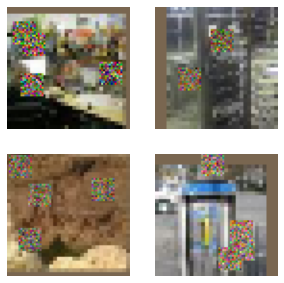

In [13]:
show_images(denorm(xb[:4]), imsize=2.5)

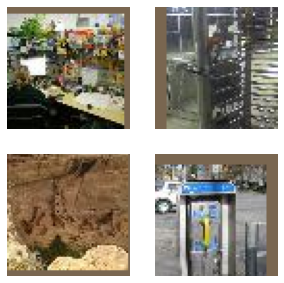

In [14]:
show_images(denorm(yb[:4]), imsize=2.5)

### Denoising Autoencoder

In [15]:
def up_block(ni, nf, ks=3, act=act_gr, norm=None):
    return nn.Sequential(nn.UpsamplingNearest2d(scale_factor=2),
                         ResBlock(ni, nf, ks=ks, act=act, norm=norm))

In [16]:
def get_model(act=act_gr, nfs=(32,64,128,256,512,1024), norm=nn.BatchNorm2d, drop=0.1):
    layers = [ResBlock(3, nfs[0], ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [up_block(nfs[i], nfs[i-1], act=act, norm=norm) for i in range(len(nfs)-1,0,-1)]
    layers += [ResBlock(nfs[0], 3, act=nn.Identity, norm=norm)]
    return nn.Sequential(*layers).apply(iw)

In [17]:
iw = partial(init_weights, leaky=0.1)

In [18]:
metrics = MetricsCB()
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), MixedPrecision()]
lr_cbs = [DeviceCB(), ProgressCB(), MixedPrecision()]
opt_func = partial(optim.AdamW, eps=1e-5)

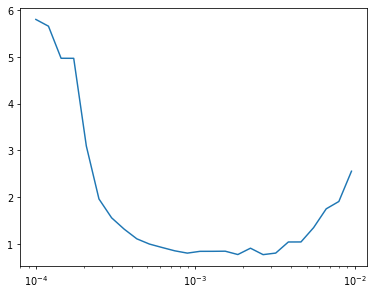

In [19]:
Learner(get_model().apply(iw), dls, F.mse_loss, cbs=lr_cbs, opt_func=opt_func).lr_find(start_lr=1e-4, gamma=1.2)

In [19]:
epochs = 5
lr = 1e-3
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = Learner(get_model().apply(iw), dls, F.mse_loss, lr=lr, cbs=cbs+xtra, opt_func=opt_func)

loss,epoch,train
0.604,0,train
0.362,0,eval
0.314,1,train
0.278,1,eval
0.251,2,train
0.224,2,eval
0.226,3,train
0.207,3,eval
0.219,4,train
0.205,4,eval


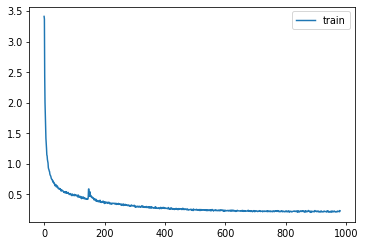

In [21]:
learn.fit(epochs)

In [ ]:
p,t,inp = learn.capture_preds(inps=True)

In [ ]:
show_images(denorm(inp[:9]), imsize=2)

In [ ]:
show_images(denorm(inp[:9]), imsize=2)

## Unet

In [ ]:
del(learn)
clean_mem()

In [20]:
class TinyUnet(nn.Module):
    """
    ModuleList does not do anything, just provides a convenient way to access different parts of the model
    Note that all of the layers are saved to facilitate passing across to the upblocks
    layer0 - x (3, 64, 64)
    layer1 - output of start (32 filters) (32, 32, 32)
    layer2 - output of first dn (64) (64, 16, 16)
    layer3 - output of first dn (128) (128, 8, 8)
    layer4 - output of first dn (256) (256, 4, 4)
    layer5 - output of first dn (512) (512, 2, 2)
    the output from the last dn layer is not stored but passed to the ups, output of first dn (1024) (1024, 1, 1)
    up0 - 1024-512 (512, 2, 2) - no input from cross
    up1 - 512-256 (256, 4, 4) - input from layer 5
    up2 - 256-128 (128, 8, 8)
    up3 - 128-64 (64, 16, 16)
    up4 - 64-32 (32, 32, 32)
    up5 - 32-3 (3, 64, 64)
    end - 3-3 * input from original x (3, 64, 64)
    
    """
    def __init__(self, act=act_gr, nfs=(32,64,128,256,512,1024), norm=nn.BatchNorm2d):
        super().__init__()
        self.start = ResBlock(3, nfs[0], stride=1, act=act, norm=norm)
        self.dn = nn.ModuleList([ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2)
                                 for i in range(len(nfs)-1)])
        self.up = nn.ModuleList([up_block(nfs[i], nfs[i-1], act=act, norm=norm)
                                 for i in range(len(nfs)-1,0,-1)])
        self.up += [ResBlock(nfs[0], 3, act=act, norm=norm)]
        self.end = ResBlock(3, 3, act=nn.Identity, norm=norm)

    def forward(self, x):
        layers = []
        layers.append(x)
        x = self.start(x)
        for l in self.dn:
            layers.append(x)
            x = l(x)
        n = len(layers)
        for i,l in enumerate(self.up):
            if i!=0: x += layers[n-i]
            x = l(x)
        return self.end(x+layers[0])

In [21]:
learn.model

Sequential(
  (0): ResBlock(
    (convs): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): GeneralRelu()
      )
      (1): Sequential(
        (0): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (idconv): Sequential(
      (0): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
    )
    (act): GeneralRelu()
  )
  (1): ResBlock(
    (convs): Sequential(
      (0): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): GeneralRelu()
      )
      (1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): 

In [22]:
def zero_wgts(l):
    with torch.no_grad():
        l.weight.zero_()
        l.bias.zero_()

In [23]:
model = TinyUnet()

In [24]:
last_res = model.up[-1]
zero_wgts(last_res.convs[-1][-1])
zero_wgts(last_res.idconv[0])
zero_wgts(model.end.convs[-1][-1])

In [25]:
epochs = 20
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = Learner(model, dls, F.mse_loss, lr=lr, cbs=cbs+xtra, opt_func=opt_func)

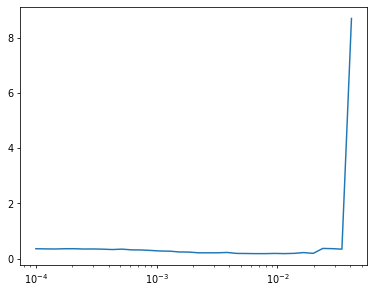

In [29]:
Learner(model, dls, F.mse_loss, cbs=lr_cbs, opt_func=opt_func).lr_find(start_lr=1e-4, gamma=1.2)


In [26]:
model = TinyUnet()

Note - the following zeros the weights of the end convs so that initially the carry across from the first layer can go straight through to the end, to help the model get started

In [27]:
last_res = model.up[-1]
zero_wgts(last_res.convs[-1][-1])
zero_wgts(last_res.idconv[0])
zero_wgts(model.end.convs[-1][-1])

In [28]:
epochs = 20
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = Learner(model, dls, F.mse_loss, lr=lr, cbs=cbs+xtra, opt_func=opt_func)

loss,epoch,train
0.161,0,train
0.085,0,eval
0.106,1,train
0.080,1,eval
0.097,2,train
0.078,2,eval
0.093,3,train
0.078,3,eval
0.092,4,train
0.077,4,eval


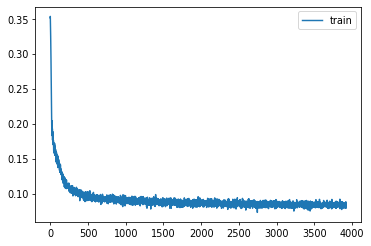

In [33]:
learn.fit(epochs)

In [34]:
p,t,inp = learn.capture_preds(inps=True)

loss,epoch,train
0.073,0,eval


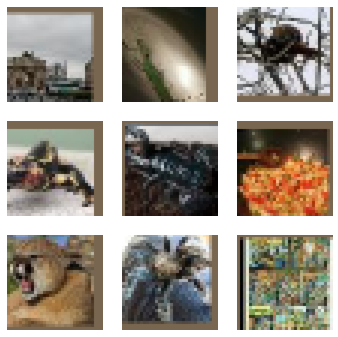

In [35]:
show_images(denorm(inp[:9]), imsize=2)

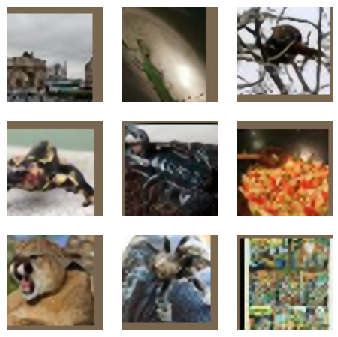

In [36]:
show_images(denorm(p[:9]), imsize=2)

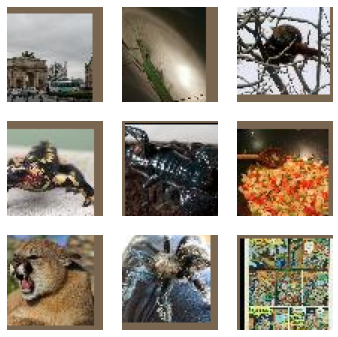

In [37]:
show_images(denorm(t[:9]), imsize=2)

In [53]:
torch.save(learn.model, "/home/models/superres-cross.pkl")

In [30]:
learn.model = torch.load("/home/models/superres-cross.pkl")

## Perceptual loss

In [ ]:
# del(learn)
# clean_mem()

In [31]:
cmodel = torch.load('/home/models/inettiny-custom-25').cuda()

In [32]:
xb,yb = next(iter(dls.valid))
with torch.autocast('cuda'),torch.no_grad(): preds = to_cpu(cmodel(yb.cuda().half()))
preds.shape

torch.Size([512, 200])

In [33]:
id2str = (path_to_dataset/'wnids.txt').read_text().splitlines()
all_synsets = [o.split('\t') for o in (path_to_dataset/'words.txt').read_text().splitlines()]
synsets = {k:v.split(',', maxsplit=1)[0] for k,v in all_synsets if k in id2str}

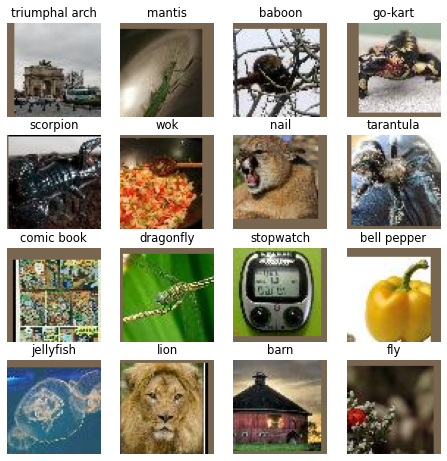

In [34]:
titles = [synsets[id2str[o]] for o in preds.argmax(dim=1)]
show_images(denorm(yb[:16]), imsize=2, titles=titles[:16])

In [35]:
for i in range(4,len(cmodel)): del(cmodel[4])

In [36]:
learn.model = torch.load('/home/models/superres-cross.pkl')

In [37]:
with torch.autocast('cuda'),torch.no_grad():
    feat = to_cpu(cmodel(yb.cuda())).float()
    t = to_cpu(learn.model(yb.cuda())).float()
    pred_feat = to_cpu(cmodel(t.cuda())).float()

feat.shape

torch.Size([512, 256, 8, 8])

In [38]:
t.shape, pred_feat.shape

(torch.Size([512, 3, 64, 64]), torch.Size([512, 256, 8, 8]))

In [41]:
(feat.sign() == pred_feat.sign()).float().mean()

tensor(0.89117)

In [42]:
def comb_loss(inp, tgt):
    """ Combine perceptual and pixel accuracy losses.  Reduce weight of perceptual by factor of 10
    """
    with torch.autocast('cuda'):
        with torch.no_grad(): tgt_feat = cmodel(tgt).float()
        inp_feat = cmodel(inp).float()
    feat_loss = F.mse_loss(inp_feat, tgt_feat)
    return F.mse_loss(inp,tgt) + feat_loss/10

In [43]:
def get_unet():
    """ Get a unet model and zero the weights of the last up layer convs and the end conv
    (leaving the idconv of the last layer to let the pass across activations go through
    """
    model = TinyUnet()
    last_res = model.up[-1]
    zero_wgts(last_res.convs[-1][-1])
    zero_wgts(last_res.idconv[0])
    zero_wgts(model.end.convs[-1][-1])
    return model

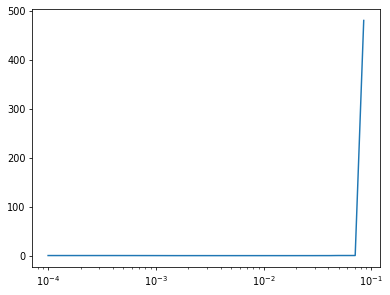

In [44]:
Learner(get_unet(), dls, comb_loss, cbs=lr_cbs, opt_func=opt_func).lr_find(start_lr=1e-4, gamma=1.2)

In [45]:
epochs = 20
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = Learner(get_unet(), dls, comb_loss, lr=lr, cbs=cbs+xtra, opt_func=opt_func)

loss,epoch,train
0.191,0,train
0.109,0,eval
0.133,1,train
0.104,1,eval
0.123,2,train
0.101,2,eval
0.118,3,train
0.101,3,eval
0.116,4,train
0.098,4,eval


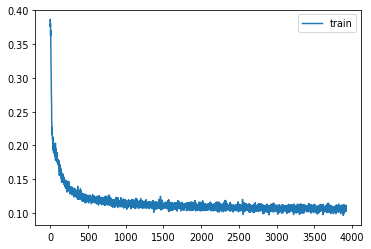

In [46]:
learn.fit(epochs)

In [47]:
p,t,inp = learn.capture_preds(inps=True)

loss,epoch,train
0.092,0,eval


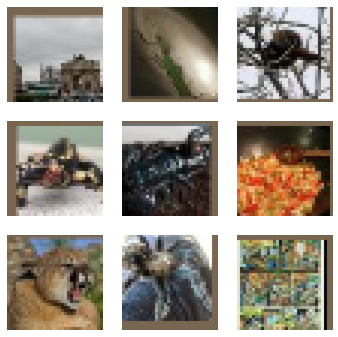

In [48]:
show_images(denorm(inp[:9]), imsize=2)

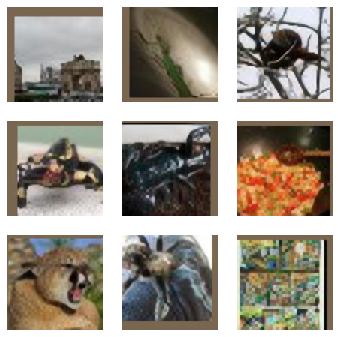

In [49]:
show_images(denorm(p[:9]), imsize=2)

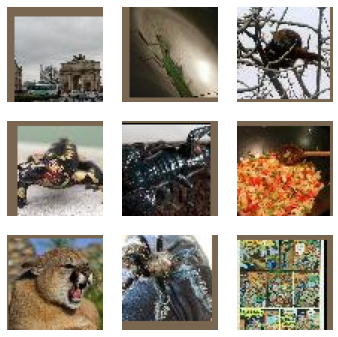

In [51]:
show_images(denorm(t[:9]), imsize=2)

In [50]:
torch.save(learn.model, '/home/models/superres-perceptual.pkl')

## Perceptual Loss part 2

This part of the notebook initializes the unet weights using the pretrained weights from the classifier and then pregressive unfreezing of weights

In [54]:
class TinyUnet(nn.Module):
    """ - Note - changed to ks=5 for start
    """
    def __init__(self, act=act_gr, nfs=(32,64,128,256,512,1024), norm=nn.BatchNorm2d):
        super().__init__()
        self.start = ResBlock(3, nfs[0], ks=5, stride=1, act=act, norm=norm)
        self.dn = nn.ModuleList([ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2)
                                 for i in range(len(nfs)-1)])
        self.up = nn.ModuleList([up_block(nfs[i], nfs[i-1], act=act, norm=norm)
                                 for i in range(len(nfs)-1,0,-1)])
        self.up += [ResBlock(nfs[0], 3, act=act, norm=norm)]
        self.end = ResBlock(3, 3, act=nn.Identity, norm=norm)

    def forward(self, x):
        layers = []
        layers.append(x)
        x = self.start(x)
        for l in self.dn:
            layers.append(x)
            x = l(x)
        n = len(layers)
        for i,l in enumerate(self.up):
            if i!=0: x += layers[n-i]
            x = l(x)
        return self.end(x+layers[0])

In [58]:
model = get_unet()

In [65]:
# needed a pmodel[i+1][0] instead of pmodel[i+1]
pmodel = torch.load('/home/models/inettiny-custom-25')
model.start.load_state_dict(pmodel[0].state_dict())
for i in range(5): model.dn[i].load_state_dict(pmodel[i+1][0].state_dict())

In [66]:
# Freeze all of the weights in the down path
for o in model.dn.parameters(): o.requires_grad_(False)

In [67]:
epochs = 1
lr = 3e-3
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = Learner(model, dls, comb_loss, lr=lr, cbs=cbs+xtra, opt_func=opt_func)

loss,epoch,train
0.178,0,train
0.109,0,eval


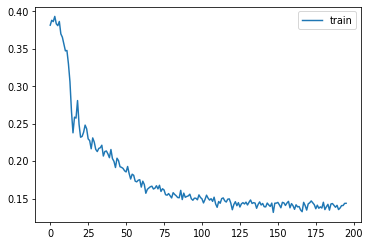

In [68]:
learn.fit(epochs)

In [69]:
# Now unfreeze the model downpath
for o in model.dn.parameters(): o.requires_grad_(True)

In [70]:
epochs = 20
lr = 3e-3
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = Learner(model, dls, comb_loss, lr=lr, cbs=cbs+xtra, opt_func=opt_func)

loss,epoch,train
0.138,0,train
0.107,0,eval
0.133,1,train
0.107,1,eval
0.128,2,train
0.104,2,eval
0.124,3,train
0.104,3,eval
0.122,4,train
0.101,4,eval


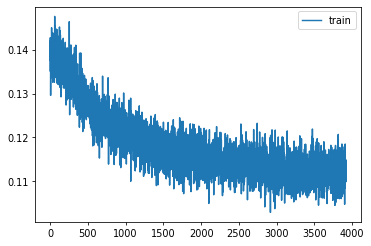

In [71]:
learn.fit(epochs)

In [72]:
torch.save(learn.model, '/home/models/superres-pcp.pkl')

In [73]:
p,t,inp = learn.capture_preds(inps=True)

loss,epoch,train
0.096,0,eval


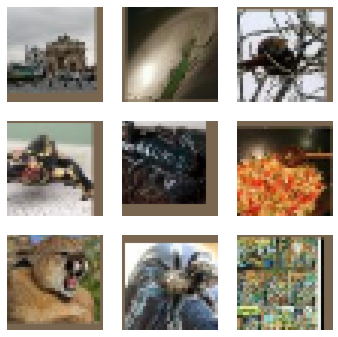

In [74]:
show_images(denorm(inp[:9]), imsize=2)

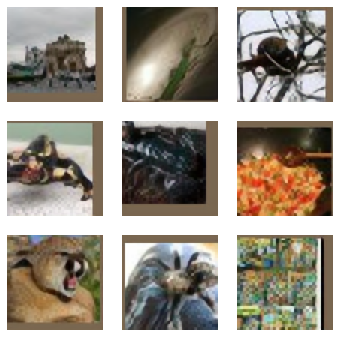

In [75]:
show_images(denorm(p[:9]), imsize=2)

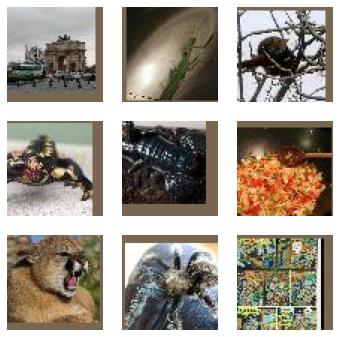

In [76]:
show_images(denorm(t[:9]), imsize=2)

## Cross Convs 

This section adds additional computation in the cross blocks to enable additional value to be added there

In [77]:
def cross_conv(nf, act, norm):
    return nn.Sequential(
        ResBlock(nf, nf, act=act, norm=norm),
        nn.Conv2d(nf, nf, 3, padding=1)
    )

In [78]:
class TinyUnet(nn.Module):
    def __init__(self, act=act_gr, nfs=(32,64,128,256,512,1024), norm=nn.BatchNorm2d):
        super().__init__()
        self.start = ResBlock(3, nfs[0], ks=5, stride=1, act=act, norm=norm)
        self.dn = nn.ModuleList([ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2)
                                 for i in range(len(nfs)-1)])
        self.xs = nn.ModuleList([cross_conv(nfs[i], act, norm)
                                 for i in range(len(nfs)-1,0,-1)])
        self.xs += [cross_conv(nfs[0], act, norm)]
        self.up = nn.ModuleList([up_block(nfs[i], nfs[i-1], act=act, norm=norm)
                                 for i in range(len(nfs)-1,0,-1)])
        self.up += [ResBlock(nfs[0], 3, act=act, norm=norm)]
        self.end = ResBlock(3, 3, act=nn.Identity, norm=norm)

    def forward(self, x):
        layers = []
        layers.append(x)
        x = self.start(x)
        for i,l in enumerate(self.dn):
            layers.append(x)
            x = l(x)
        n = len(layers)
        for i,l in enumerate(self.up):
            if i!=0: x += self.xs[i](layers[n-i])
            x = l(x)
        return self.end(x+layers[0])

Note - try adding a cross conv on the start to end

In [79]:
pmodel = torch.load('/home/models/inettiny-custom-25')

In [80]:
model = get_unet()

In [81]:
model.start.load_state_dict(pmodel[0].state_dict())
for i in range(5): model.dn[i].load_state_dict(pmodel[i+1][0].state_dict())
for o in model.dn.parameters(): o.requires_grad_(False)

In [82]:
epochs = 1
lr = 3e-3
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = Learner(model, dls, comb_loss, lr=lr, cbs=cbs+xtra, opt_func=opt_func)

loss,epoch,train
0.168,0,train
0.106,0,eval


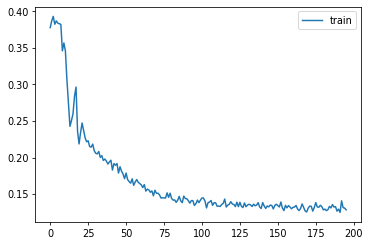

In [83]:
learn.fit(epochs)

In [84]:
for o in model.dn.parameters(): o.requires_grad_(True)

In [85]:
epochs = 20
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = Learner(model, dls, comb_loss, lr=lr, cbs=cbs+xtra, opt_func=opt_func)

loss,epoch,train
0.129,0,train
0.103,0,eval
0.123,1,train
0.101,1,eval
0.120,2,train
0.100,2,eval
0.118,3,train
0.099,3,eval
0.116,4,train
0.098,4,eval


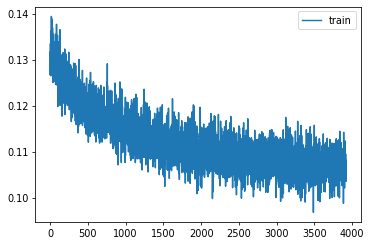

In [86]:
learn.fit(epochs)

In [87]:
p,t,inp = learn.capture_preds(inps=True)

loss,epoch,train
0.093,0,eval


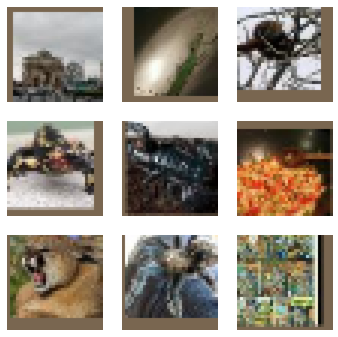

In [88]:
show_images(denorm(inp[:9]), imsize=2)

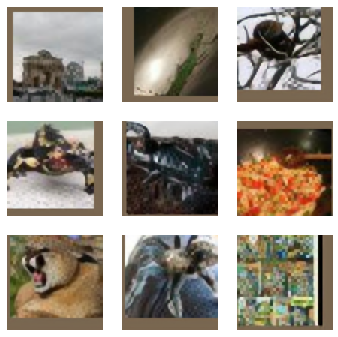

In [89]:
show_images(denorm(p[:9]), imsize=2)

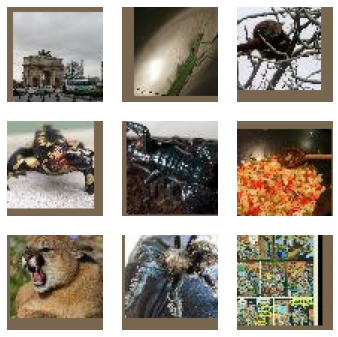

In [90]:
show_images(denorm(t[:9]), imsize=2)

In [91]:
torch.save(learn.model, 'models/superres-cross.pkl')
# learn.model = torch.load('models/superres-pcp.pkl').cuda()